In [83]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import glob
import re
from mpl_toolkits import mplot3d
import os
from scipy.stats import rankdata
from sklearn import metrics
import math

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


C:\Python37\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [84]:
myAmino = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
FullAmino = ['ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HIS', 'ILE', 'LYS', 'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG', 'SER', 'THR', 'VAL', 'TRP', 'TYR']
aminos = {FullAmino[i]:myAmino[i] for i in range(len(myAmino))}

# zero is used as padding
AA_to_int = {
    'A': 1,
    'ALA': 1,
    'C': 2,
    'CYS': 2,
    'D': 3,
    'ASP': 3,
    'E': 4,
    'GLU': 4,
    'F': 5,
    'PHE': 5,
    'G': 6,
    'GLY': 6,
    'H': 7,
    'HIS': 7,
    'I': 8,
    'ILE': 8,
    'K': 9,
    'LYS': 9,
    'L': 10,
    'LEU': 10,
    'M': 11,
    'MET': 11,
    'N': 12,
    'ASN': 12,
    'P': 13,
    'PRO': 13,
    'Q': 14,
    'GLN': 14,
    'R': 15,
    'ARG': 15,
    'S': 16,
    'SER': 16,
    'T': 17,
    'THR': 17,
    'V': 18,
    'VAL': 18,
    'W': 19,
    'TRP': 19,
    'Y': 20,
    'TYR': 20,
    'X': 21
}
## amino acid to integer
atoi = {key: val - 1 for key, val in AA_to_int.items()}
## integer to amino acid
iota = {y: x for x, y in atoi.items() if len(x) == 1}

In [85]:
#Benchmark dataset from SORTCERY
AllName = ["x1","m1","f100"]
#New name
NameTest = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

ApoDTerm = False

In [86]:
#Dictionnary of energy (exp or predicted)
PepBindEner = dict()

#Get Energy from sortery
for (t,name) in zip(AllName,NameTest):
    subdf = pd.read_csv("../SORTCERY_data/"+t+"_merged.csv")
    
    if name not in PepBindEner:
        PepBindEner[name] = dict()
    for (seq,val) in zip(subdf["protein"],subdf[t+"_mean_ener"]):
        if seq in PepBindEner[name]:
            print(name,seq,val,PepBindEner[name][seq])
        PepBindEner[name][seq] = float(val)
    print(t,name,len(subdf),len(PepBindEner[name]))
    
    
#Load Binary
for (t,n) in zip(AllName,NameTest):
    subdf = pd.read_csv("../SORTCERY_data/"+t+"_binary_merged.csv")
    name = "binary_"+n
    if name not in PepBindEner:
        PepBindEner[name] = dict()
    for (seq,val) in zip(subdf["protein"],subdf["binder"]):
        if seq in PepBindEner[name]:
            continue
            print(name,seq,val,PepBindEner[name][seq])
        PepBindEner[name][seq] = float(val)
    print(t,name,len(subdf),len(PepBindEner[name]))
    #100-80*subdf["binder"]

x1 B2CL1_SORTCERY 4386 4386
m1 MCL1_SORTCERY 4491 4491
f100 B2LA1_SORTCERY 3805 3805
x1 binary_B2CL1_SORTCERY 1882 1872
m1 binary_MCL1_SORTCERY 1940 1855
f100 binary_B2LA1_SORTCERY 1686 1686


In [87]:
#Load Bcl-2 Protoeme screen
Bcl2Prot = pd.read_table("../SORTCERY_data/bcl2_proteome_screen.dat")
for (uni,sname) in zip(["B2CL1","MCL1","B2LA1"],["Bcl-xL","Mcl-1","Bfl-1"]):
    print(uni,sname)
    name = "binary_"+uni+"_Proteome"
    if name not in PepBindEner:
        PepBindEner[name] = dict()
    subdf = Bcl2Prot.dropna(subset=[sname])
    for (seq,val) in zip(subdf["Peptide"],subdf[sname]):
        nseq = "AA"+seq
        PepBindEner[name][nseq] = float(val=="binder")

B2CL1 Bcl-xL
MCL1 Mcl-1
B2LA1 Bfl-1


In [88]:
#Get Score from FoldX and Rosetta
AllEnergyRos = pickle.load( open( "../computed_data/RosFoldEner.pickle", "rb" ))

In [89]:
for mod in AllEnergyRos.keys():
    if re.search("_Rosetta$",mod):
        continue
    #Make new model name so last term is the model name
    RegMatch = re.search("^(\S+_holo_)(\S+)$",mod)
    nmod = RegMatch.group(1)+"".join(RegMatch.group(2).split("_"))
    
    #Init dict
    if mod not in PepBindEner:
        PepBindEner[nmod] = dict()
    
    for seq in AllEnergyRos[mod]:
        if None == AllEnergyRos[mod][seq]:
            print(seq,mod)
            continue
        if not re.search("\d+",str(AllEnergyRos[mod][seq])):
            print(seq,mod,AllEnergyRos[mod][seq])
            continue
        PepBindEner[nmod][seq] = float(AllEnergyRos[mod][seq])

In [92]:
def load_dTERMen_sc(etab):
    #Initialise and read energy table        
    allpos = []
    lines = [line.replace("B,","").rstrip('\n') for line in open(etab)]
    holo = dict()
    AllSelf = []
    for l in lines:
        #print(l)
        sp = re.split("\s+",l)
        allpos.append(int(sp[0]))
        if len(sp) == 3:
            AllSelf.append(float(sp[2]))
            k1 = sp[0]+myAmino[FullAmino.index(sp[1])]
            if k1 not in holo:
                holo[k1] = dict()
            holo[k1][k1] = float(sp[2])
            continue
        if len(sp) == 5:
            k1 = sp[0]+myAmino[FullAmino.index(sp[2])]
            k2 = sp[1]+myAmino[FullAmino.index(sp[3])]
            holo[k1][k2] = float(sp[4])
            AllSelf.append(float(sp[4]))
            continue
        print(l)
        break
        
    #Keep only unique position
    allpos = sorted(list(set(allpos)))
    return(holo,allpos)

def old_self_energies(query):
    self_e = []

    alletab = glob.glob(query)
    for etab in sorted(alletab):
        #Get Model name
        model = re.search("([A-Za-z0-9_]+)\.etab",etab).group(1)

        #Load scoring matrix
        (holo,allpos) = load_dTERMen_sc(etab)
        
        # if len(allpos) != 20:
            # print(model,len(allpos))
            # continue
        
        for pos in allpos:
            for elem in myAmino:
                k = str(pos)+elem
                self_e.append(holo[k][k])
    
    return self_e

In [91]:
def self_energies(query):
    self_e = []

    alletab = glob.glob(query)
    for etab in sorted(alletab):
        model = etab[:etab.index("condensed")]
        table = np.load(etab)
        for i in range(len(table)):
            # for j in range(len(table[0][0])):
            for j in range(20):
                self_e.append(table[i][i][j][j])
    
    return self_e

In [90]:
#Score seq using energy function
def score_sec(seq,mat):
    sc = 0.0
    chain_size = len(seq)
    for i in range(0, chain_size):
        amino1 = atoi[seq[i]]
        for j in range(i, chain_size):
            amino2 = atoi[seq[j]]
            sc += mat[i][j][amino1][amino2]
    return sc

In [93]:
ApoDTerm = False
CHAIN_LENGTH = 20
# ener_original = []
# ener_predicted = []

alletab = glob.glob("../../frappier_termless_np/tic0/*condensed.etab.npy")
for etab in alletab:
    model = os.path.basename(etab)
    if "BCL2" in model or "HUMAN" not in model:
        continue

    sp = model.split("_")
    if len(sp) != 6:
        continue
    rec = sp[0]
    
    scoring = "dTERMenC"
    sp[-1] = scoring+sp[-1][:2]
    nmodel = "_".join(sp)

    #Load scoring matrix
    holo = np.load(etab)

    if len(holo) != CHAIN_LENGTH: # check for length 20 chain
        print(model,len(holo))
        continue

    print("now scoring:", model)

    if nmodel not in PepBindEner:
        PepBindEner[nmodel] = dict()
    for seq in PepBindEner[rec+"_SORTCERY"]:
        #dTERMen pep are shorter, so need to adjust
        SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
        #Score Seq
        ener = score_sec(SeqToScore,holo)
        PepBindEner[nmodel][seq] = ener
        
    for seq in PepBindEner["binary_"+rec+"_SORTCERY"]:
        #dTERMen pep are shorter, so need to adjust
        SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
        #Score Seq
        ener = score_sec(SeqToScore,holo)
        PepBindEner[nmodel][seq] = ener
        
    for seq in PepBindEner["binary_"+rec+"_Proteome"]:
        #dTERMen pep are shorter, so need to adjust
        SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
        #Score Seq
        ener = score_sec(SeqToScore,holo)
        PepBindEner[nmodel][seq] = ener

B2CL1_HUMAN_1BXL_A_holo_35condensed.etab.npy 16
now scoring: B2CL1_HUMAN_1G5J_A_holo_35condensed.etab.npy
now scoring: B2CL1_HUMAN_2M04_A_holo_35condensed.etab.npy
now scoring: B2CL1_HUMAN_2P1L_A_holo_35condensed.etab.npy
now scoring: B2CL1_HUMAN_2P1L_C_holo_35condensed.etab.npy
now scoring: B2CL1_HUMAN_2P1L_E_holo_35condensed.etab.npy
now scoring: B2CL1_HUMAN_2P1L_G_holo_35condensed.etab.npy
now scoring: B2CL1_HUMAN_2PON_B_holo_35condensed.etab.npy
B2CL1_HUMAN_2YQ7_A_holo_35condensed.etab.npy 17
now scoring: B2CL1_HUMAN_3FDL_A_holo_35condensed.etab.npy
now scoring: B2CL1_HUMAN_3IO8_A_holo_35condensed.etab.npy
B2CL1_HUMAN_3IO8_C_holo_35condensed.etab.npy 18
now scoring: B2CL1_HUMAN_3PL7_A_holo_35condensed.etab.npy
B2CL1_HUMAN_3R85_A_holo_35condensed.etab.npy 19
B2CL1_HUMAN_3R85_B_holo_35condensed.etab.npy 17
B2CL1_HUMAN_3R85_C_holo_35condensed.etab.npy 18
B2CL1_HUMAN_3R85_D_holo_35condensed.etab.npy 17
now scoring: B2CL1_HUMAN_4CIN_A_holo_35condensed.etab.npy
B2CL1_HUMAN_4CIN_B_holo_35

In [94]:
#Find how often each pdb is there
PDBCount = dict()
MaxPDB = 0
for k in sorted(PepBindEner.keys()):
    if len(PepBindEner[k]) < 1500:
        #print(k)
        continue
        die
    sp = k.split("_")
    if len(sp) < 6:
        continue
    pdb = "_".join(sp[0:4])
    if pdb not in PDBCount:
        PDBCount[pdb] = 0
    PDBCount[pdb] += 1
    if PDBCount[pdb] > MaxPDB:
        MaxPDB = PDBCount[pdb]
    #print(pdb,k,len(PepBindEner[k]))

#Remove incomplete template
for k in sorted(PepBindEner.keys()):
    if len(PepBindEner[k]) < 1500:
        #print(k)
        continue
    sp = k.split("_")
    if len(sp) < 6:
        continue
    pdb = "_".join(sp[0:4])
    if PDBCount[pdb] != MaxPDB:
        if k in PepBindEner:
            print(k,PDBCount[pdb],MaxPDB)
            del PepBindEner[k]
    

B2CL1_HUMAN_1BXL_A_holo_FoldX 7 8
B2CL1_HUMAN_1BXL_A_holo_RosettaTalarisInterfacedGcross 7 8
B2CL1_HUMAN_1BXL_A_holo_RosettaTalarisInterfacedGseparated 7 8
B2CL1_HUMAN_1BXL_A_holo_RosettaTalarisPose 7 8
B2CL1_HUMAN_1BXL_A_holo_RosettabetaInterfacedGcross 7 8
B2CL1_HUMAN_1BXL_A_holo_RosettabetaInterfacedGseparated 7 8
B2CL1_HUMAN_1BXL_A_holo_RosettabetaPose 7 8
B2CL1_HUMAN_2YQ7_A_holo_FoldX 7 8
B2CL1_HUMAN_2YQ7_A_holo_RosettaTalarisInterfacedGcross 7 8
B2CL1_HUMAN_2YQ7_A_holo_RosettaTalarisInterfacedGseparated 7 8
B2CL1_HUMAN_2YQ7_A_holo_RosettaTalarisPose 7 8
B2CL1_HUMAN_2YQ7_A_holo_RosettabetaInterfacedGcross 7 8
B2CL1_HUMAN_2YQ7_A_holo_RosettabetaInterfacedGseparated 7 8
B2CL1_HUMAN_2YQ7_A_holo_RosettabetaPose 7 8
B2CL1_HUMAN_3IO8_C_holo_FoldX 7 8
B2CL1_HUMAN_3IO8_C_holo_RosettaTalarisInterfacedGcross 7 8
B2CL1_HUMAN_3IO8_C_holo_RosettaTalarisInterfacedGseparated 7 8
B2CL1_HUMAN_3IO8_C_holo_RosettaTalarisPose 7 8
B2CL1_HUMAN_3IO8_C_holo_RosettabetaInterfacedGcross 7 8
B2CL1_HUMAN_3IO

In [95]:
#Get Min
#Find model

MinPDBTemp = dict()

for k in sorted(PepBindEner.keys()):
    sp = k.split("_")
    if len(sp) != 6:
        #print(k)
        continue
    
    mod = "_".join(sp[:2]+["MIN",sp[-1]])
    pdb = "_".join(k.split("_")[:4])
    
    if mod not in PepBindEner:
        PepBindEner[mod] = dict()
    #print(k,len(sp),mod)
    for seq in PepBindEner[k]:
        if seq not in PepBindEner[mod]:
            PepBindEner[mod][seq] = PepBindEner[k][seq]
        if mod not in MinPDBTemp:
            MinPDBTemp[mod] = dict()
        if PepBindEner[k][seq] <= PepBindEner[mod][seq]:
            PepBindEner[mod][seq] = PepBindEner[k][seq]
            
            MinPDBTemp[mod][seq] = pdb
#Get MinPDB count
MinPDB = dict()
for mod in MinPDBTemp.keys():
    submod = mod.split("_")[-1]
    if submod not in MinPDB:
        MinPDB[submod] = dict()
    for seq in MinPDBTemp[mod]:
        pdb = MinPDBTemp[mod][seq]
        if pdb not in MinPDB[submod]:
            MinPDB[submod][pdb] = 0
        MinPDB[submod][pdb] += 1

In [96]:
PepBindEnerKey = PepBindEner.keys()
for model in PepBindEnerKey:
    if ApoDTerm == False:continue
    if "dTERMenC" not in model:continue
    apo_model = re.sub("holo_dTERMenC","apo_dTERMenA",model)
    if "MIN" in model:
        apo_model = re.sub("dTERMenC","dTERMenA",model)
    if apo_model not in PepBindEner:
        print(model)
        continue
    dif_model = re.sub("dTERMenC","dTERMenD",model)
    PepBindEner[dif_model] = dict()
    for seq in PepBindEner[model]:
        PepBindEner[dif_model][seq] =  PepBindEner[model][seq] - PepBindEner[apo_model][seq]
        #print(seq,PepBindEner[model][seq],PepBindEner[apo_model][seq],PepBindEner[dif_model][seq])
    


In [34]:
PepBindEnerDF = pd.DataFrame(PepBindEner).dropna(axis=1, how='all').dropna(axis=0, how='all')

In [35]:
PepBindEnerDF.to_csv("../computed_data/PepBindEnerDF_recomputed.csv")
pickle.dump(PepBindEnerDF,open("../computed_data/PepBindEnerDF_recomputed.pickle","wb"))

In [39]:
PepBindEnerDF["B2CL1_SORTCERY"]

GQAAADVGAQLRRMADDYNAQY   -11.742132
GQAAAHVGAQLRRMADDVQAQY   -11.081939
GQAAAQIVAQLIRMADDVEAQY    -9.537042
GQAACDVIAQLKRMADDLHAQY    -9.713138
GQAACEVSAQLIRMADDVNAQY    -9.564128
                            ...    
GQWKREIDAILRRVADVVNAQV          NaN
GQPACQVTAQLIRMADDTDAQY          NaN
GRGECHIVQELVRIGDEINAYY          NaN
DRPLIWIYQILRRAGDVLNAYF          NaN
GRPEADIGQELRRIGDEFDAYY          NaN
Name: B2CL1_SORTCERY, Length: 7262, dtype: float64

In [43]:
PepBindEnerDF["B2CL1_HUMAN_1G5J_A_holo_dTERMenC35"]

GQAAADVGAQLRRMADDYNAQY   -126.603261
GQAAAHVGAQLRRMADDVQAQY   -121.777303
GQAAAQIVAQLIRMADDVEAQY   -115.143554
GQAACDVIAQLKRMADDLHAQY   -120.152336
GQAACEVSAQLIRMADDVNAQY   -112.748160
                             ...    
GQWKREIDAILRRVADVVNAQV           NaN
GQPACQVTAQLIRMADDTDAQY           NaN
GRGECHIVQELVRIGDEINAYY           NaN
DRPLIWIYQILRRAGDVLNAYF           NaN
GRPEADIGQELRRIGDEFDAYY           NaN
Name: B2CL1_HUMAN_1G5J_A_holo_dTERMenC35, Length: 7262, dtype: float64

In [40]:
PepBindEnerDF.columns

Index(['B2CL1_SORTCERY', 'MCL1_SORTCERY', 'B2LA1_SORTCERY',
       'binary_B2CL1_SORTCERY', 'binary_MCL1_SORTCERY',
       'binary_B2LA1_SORTCERY', 'binary_B2CL1_Proteome',
       'binary_MCL1_Proteome', 'binary_B2LA1_Proteome',
       'MCL1_HUMAN_3KJ2_A_holo_FoldX',
       ...
       'B2LA1_HUMAN_MIN_RosettabetaPose', 'B2LA1_HUMAN_MIN_dTERMenC35',
       'MCL1_HUMAN_MIN_FoldX', 'MCL1_HUMAN_MIN_RosettaTalarisInterfacedGcross',
       'MCL1_HUMAN_MIN_RosettaTalarisInterfacedGseparated',
       'MCL1_HUMAN_MIN_RosettaTalarisPose',
       'MCL1_HUMAN_MIN_RosettabetaInterfacedGcross',
       'MCL1_HUMAN_MIN_RosettabetaInterfacedGseparated',
       'MCL1_HUMAN_MIN_RosettabetaPose', 'MCL1_HUMAN_MIN_dTERMenC35'],
      dtype='object', length=401)

In [112]:
PepBindEnerDF = pickle.load( open("../../dTERMen_design_rerun_chain/computed_data/PepBindEnerDF.pickle","rb"))

B2CL1_SORTCERY


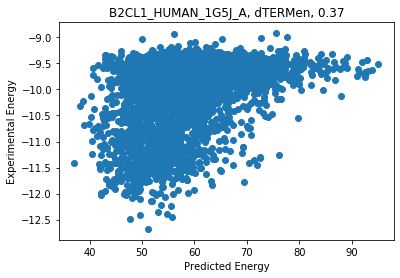

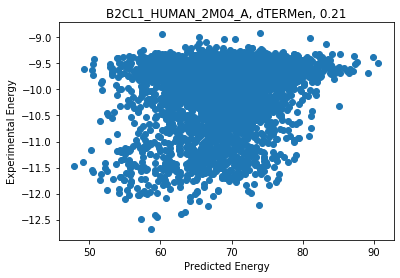

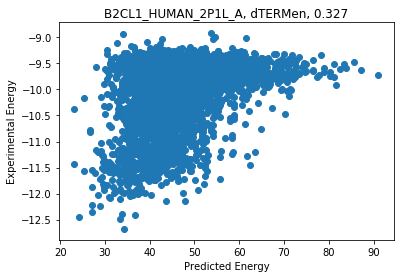

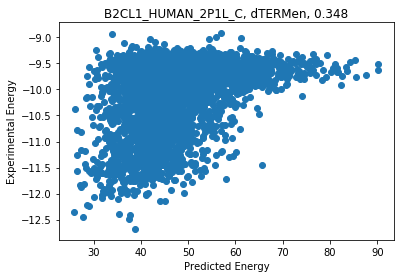

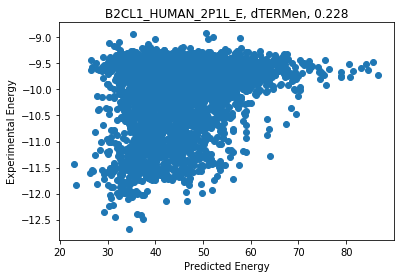

MCL1_SORTCERY


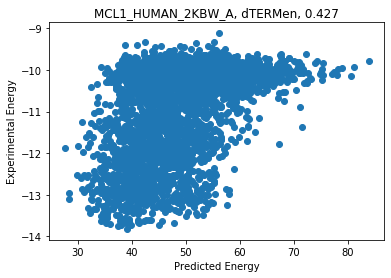

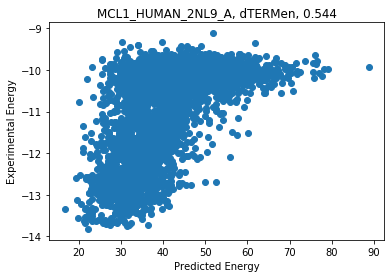

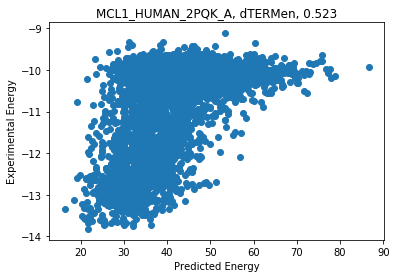

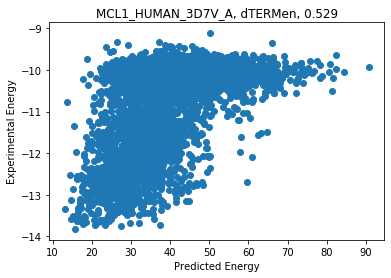

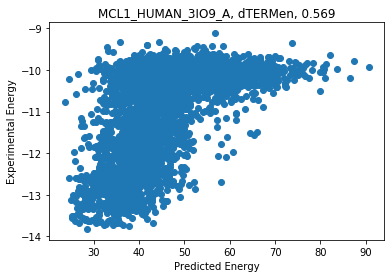

B2LA1_SORTCERY


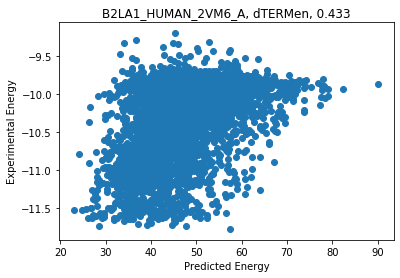

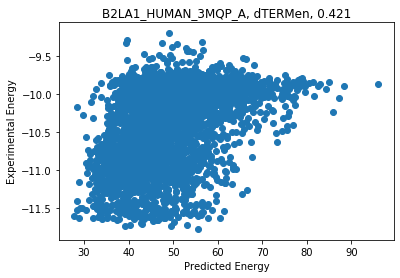

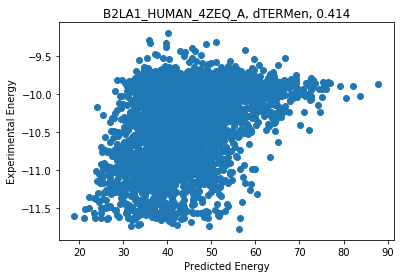

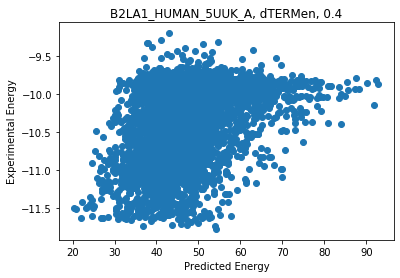

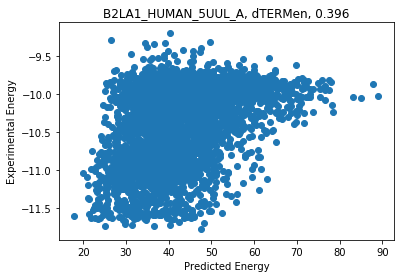

In [120]:
#New name
NameTest = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]
# NameTest = ["MCL1_SORTCERY"]


#Get Correlation and AUC

#Dict with metric
ModCor = dict()
ModAUC = dict()
ModEnr = dict()
ModProtAUC = dict()

dtermenPreds = []
dtermenExps = []
for bench in NameTest:
    print(bench)
    ExpRec = bench.split("_")[0]
    #Get bench
    OnlyBench = PepBindEnerDF.dropna(subset=[bench])
    
    #Get Binary
    binary_bench = "binary_"+bench
    BinaryOnlyBench = PepBindEnerDF.dropna(subset=[binary_bench])

    Preds = []
    Exps = []

    count = 0
    for template in sorted(list(PepBindEnerDF.columns)):
        if template == bench:continue
        #Need to be same receptor
        TempRec = template.split("_")[0]
        if TempRec != ExpRec:
            continue
            
        #Get PDB and model name
        sp = template.split("_")
        mod = sp[-1]
        pdb = "_".join(sp[:4])
        if "MIN" in template:
            pdb = "_".join(sp[:3])
        
        if mod != "dTERMenC35":
            continue
        
        count += 1
        if count > 5: # only generates plots for the first 5 structures for each family, for brevity
            break
        
        #Get data
        # subdf = OnlyBench.dropna(subset=[template]).sort_values(by=template)
        subdf = OnlyBench.dropna(subset=[template]).sort_index()
        Pred = subdf[template].values
        Exp = subdf[bench].values
        cor =  np.corrcoef(Pred,Exp)[0][1]

        Preds.extend(Pred)
        Exps.extend(Exp)

        dtermenPreds.append(Pred)
        dtermenExps.append(Exp)

        plt.scatter(Pred, Exp)
        plt.title("{}, dTERMen, {}".format(pdb,round(cor,3)))
        plt.xlabel("Predicted Energy")
        plt.ylabel("Experimental Energy")
        plt.show()
    
    # dtermenPreds.append(Preds)
    # dtermenExps.append(Exps)

In [99]:
PepBindEnerDF2 = pickle.load( open("../computed_data/PepBindEnerDF_recomputed.pickle","rb")) # here, _recomputed refers to TERMless TERMinator (COORDinator) results

B2CL1_SORTCERY


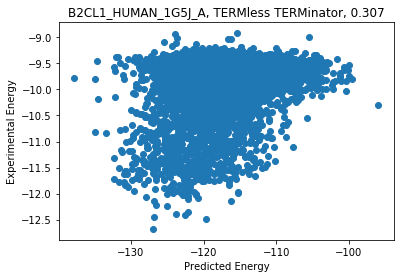

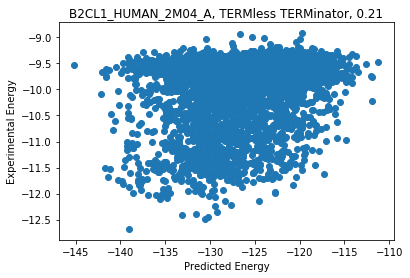

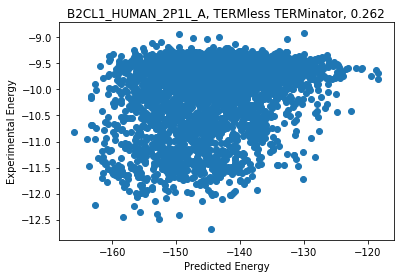

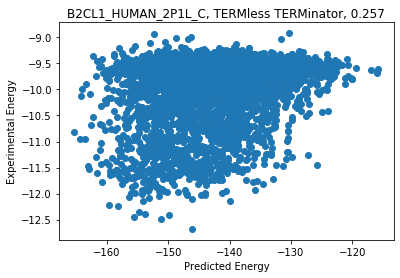

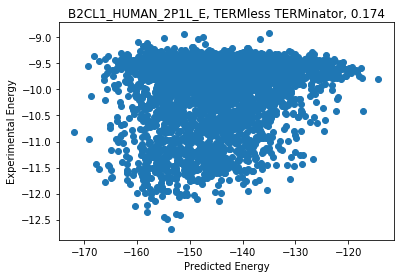

MCL1_SORTCERY


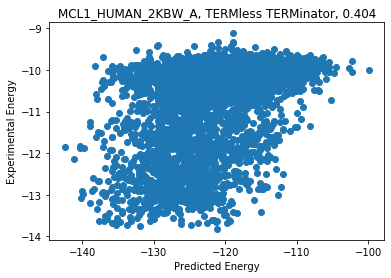

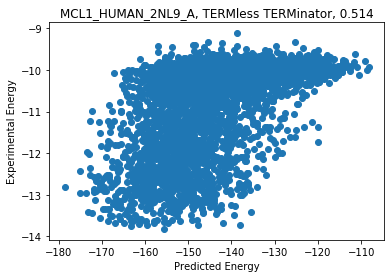

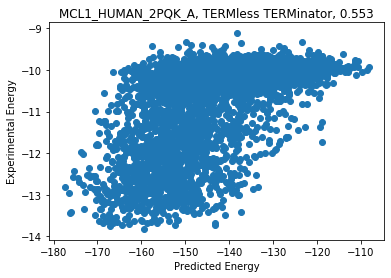

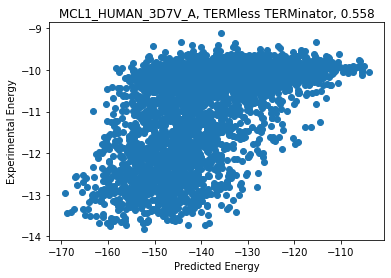

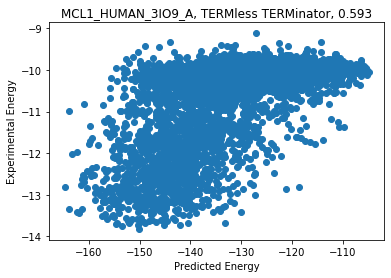

B2LA1_SORTCERY


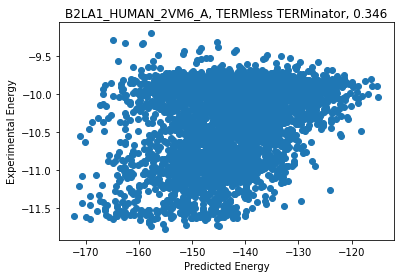

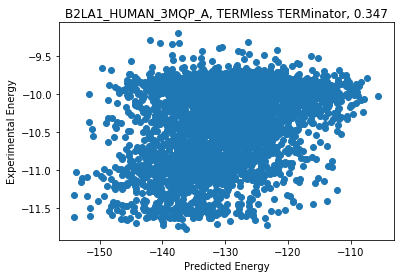

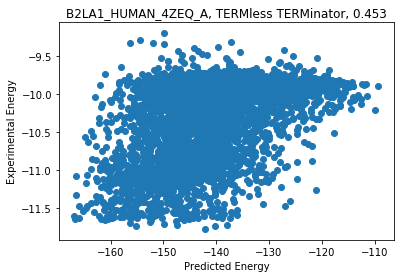

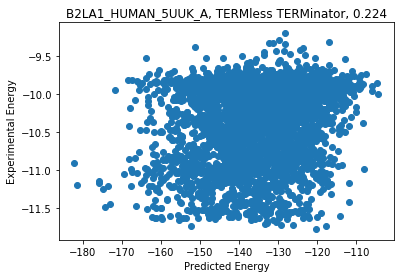

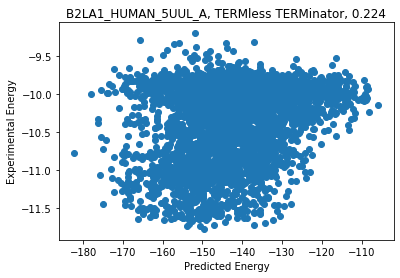

In [121]:
#New name
NameTest = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

terminatorPreds = []
terminatorExps = []
pdbsTest = []

for bench in NameTest:
    print(bench)
    ExpRec = bench.split("_")[0]
    #Get bench
    OnlyBench = PepBindEnerDF2.dropna(subset=[bench])
    
    #Get Binary
    binary_bench = "binary_"+bench
    BinaryOnlyBench = PepBindEnerDF2.dropna(subset=[binary_bench])

    Preds = []
    Exps = []

    count = 0
    for template in sorted(list(PepBindEnerDF2.columns)):
        if template == bench:continue
        #Need to be same receptor
        TempRec = template.split("_")[0]
        if TempRec != ExpRec:
            continue
            
        #Get PDB and model name
        sp = template.split("_")
        mod = sp[-1]
        pdb = "_".join(sp[:4])
        if "MIN" in template:
            pdb = "_".join(sp[:3])
        
        if mod != "dTERMenC35":
            continue
        count += 1
        if count > 5:
            break

        #Get data
        # subdf = OnlyBench.dropna(subset=[template]).sort_values(by=template)
        subdf = OnlyBench.dropna(subset=[template]).sort_index()
        Pred = subdf[template].values
        Exp = subdf[bench].values
        cor =  np.corrcoef(Pred,Exp)[0][1]

        Preds.extend(Pred)
        Exps.extend(Exp)

        terminatorPreds.append(Pred)
        terminatorExps.append(Exp)
        pdbsTest.append(pdb)


        plt.scatter(Pred, Exp)
        plt.title("{}, TERMless TERMinator, {}".format(pdb,round(cor,3)))
        plt.xlabel("Predicted Energy")
        plt.ylabel("Experimental Energy")
        plt.show()
    
    # terminatorPreds.append(Preds)
    # terminatorExps.append(Exps)


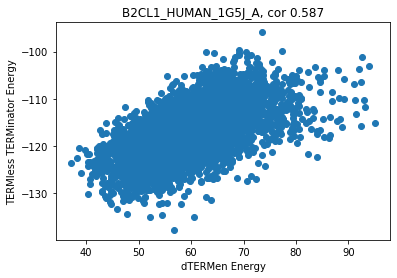

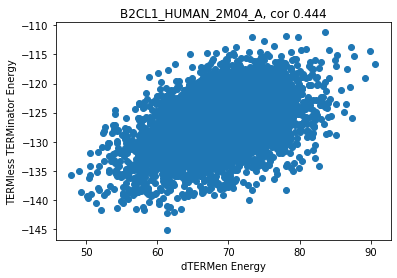

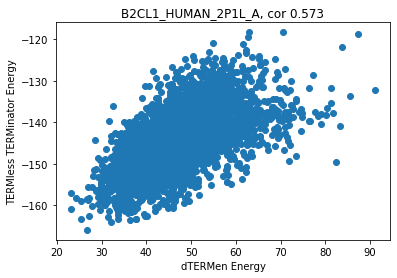

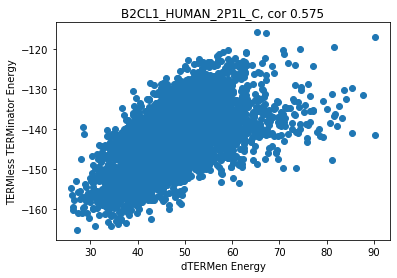

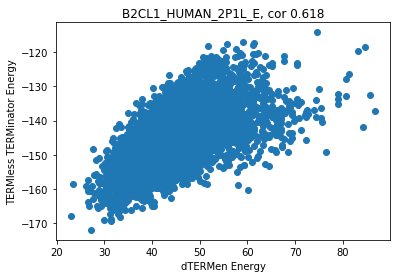

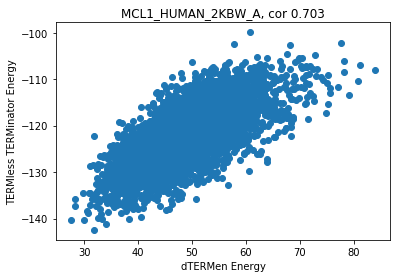

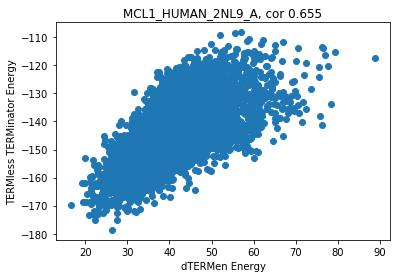

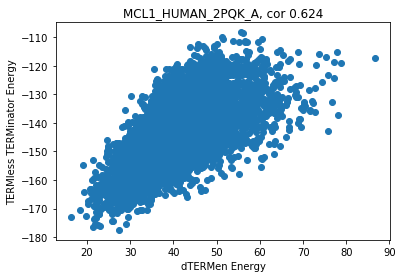

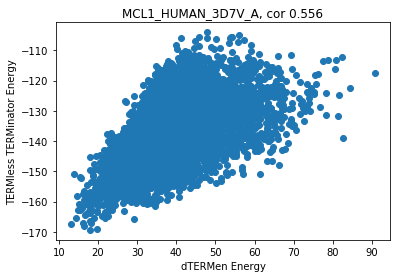

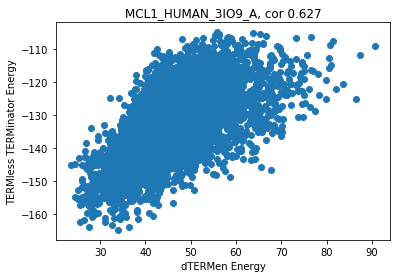

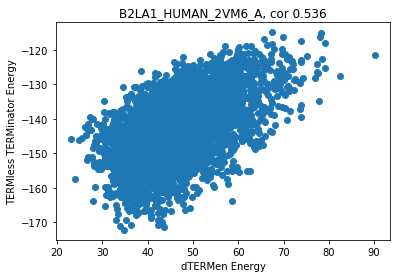

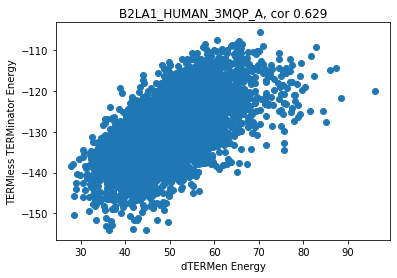

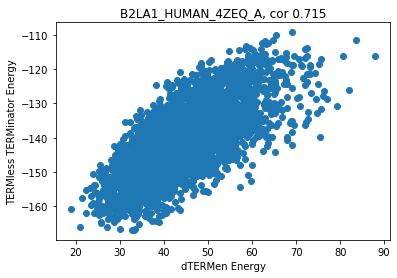

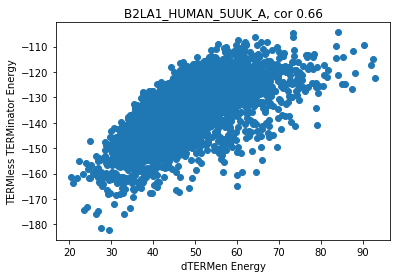

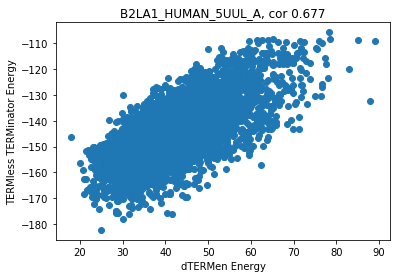

In [122]:
# plot correlations between dTERMen and COORDinator predictions for the SORTCERY dataset

for i in range(len(dtermenPreds)):
    plt.scatter(dtermenPreds[i], terminatorPreds[i])
    cor =  np.corrcoef(dtermenPreds[i],terminatorPreds[i])[0][1]
    plt.title("{}, cor {}".format(pdbsTest[i],round(cor,3)))
    plt.xlabel("dTERMen Energy")
    plt.ylabel("TERMless TERMinator Energy")
    plt.show()

In [80]:
self_1 = self_energies("../../frappier_termless_np/tic0/B2CL1*condensed.etab.npy")
self_2 = self_energies("../../frappier_full_dtermen_np/B2CL1*_35condensed.etab.npy")
self_22 = old_self_energies("../etab_bench/B2CL1*_35.etab")

Text(0.5, 1.0, 'Bcl-xL Peptide Self Energies')

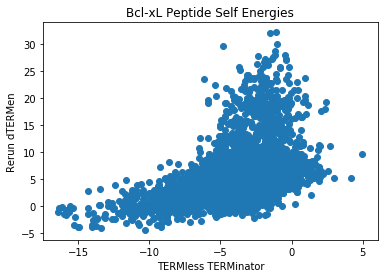

In [81]:
plt.scatter(self_1,self_2)
plt.xlabel("TERMless TERMinator")
plt.ylabel("Rerun dTERMen")
plt.title("Bcl-xL Peptide Self Energies")

Text(0.5, 1.0, 'Bcl-xL Peptide Self Energies')

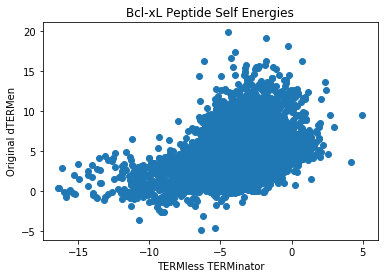

In [82]:
plt.scatter(self_1,self_22)
plt.xlabel("TERMless TERMinator")
plt.ylabel("Original dTERMen")
plt.title("Bcl-xL Peptide Self Energies")

In [123]:
self_3 = self_energies("../../frappier_termless_np/tic0/B2LA1*condensed.etab.npy")
self_4 = self_energies("../../frappier_full_dtermen_np/B2LA1*_35condensed.etab.npy")

Text(0.5, 1.0, 'Bfl-1 Peptide Self Energies')

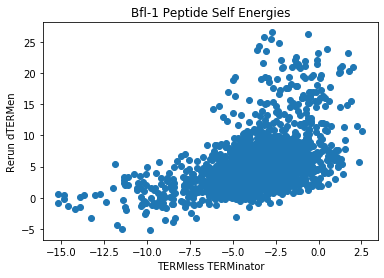

In [124]:
plt.scatter(self_3,self_4)
plt.xlabel("TERMless TERMinator")
plt.ylabel("Rerun dTERMen")
plt.title("Bfl-1 Peptide Self Energies")

In [125]:
self_5 = self_energies("../../frappier_termless_np/tic0/MCL1*condensed.etab.npy")
self_6 = self_energies("../../frappier_full_dtermen_np/MCL1*_35condensed.etab.npy")

Text(0.5, 1.0, 'Mcl-1 Peptide Self Energies')

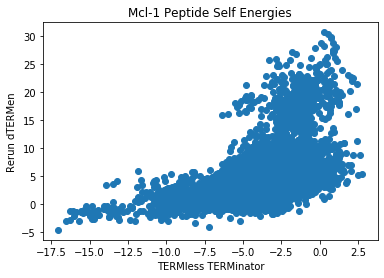

In [126]:
plt.scatter(self_5,self_6)
plt.xlabel("TERMless TERMinator")
plt.ylabel("Rerun dTERMen")
plt.title("Mcl-1 Peptide Self Energies")